In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
from PIL import Image 
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob
import cv2
from tensorflow.keras import backend as K

In [ ]:
for dirpath,dirnames,filenames in os.walk("/content/drive/MyDrive/research_tra/main"):
  print(f"There are len{len(dirnames)} directories and {len(filenames)} image in '{dirpath}'.")

There are len2 directories and 0 image in '/content/drive/MyDrive/research_tra/main'.
There are len7 directories and 0 image in '/content/drive/MyDrive/research_tra/main/Train'.
There are len0 directories and 4043 image in '/content/drive/MyDrive/research_tra/main/Train/bcc_1'.
There are len0 directories and 3904 image in '/content/drive/MyDrive/research_tra/main/Train/nv_1'.
There are len0 directories and 3978 image in '/content/drive/MyDrive/research_tra/main/Train/bkl_1'.
There are len0 directories and 4082 image in '/content/drive/MyDrive/research_tra/main/Train/akeic_1'.
There are len0 directories and 4279 image in '/content/drive/MyDrive/research_tra/main/Train/mel_1'.
There are len0 directories and 4208 image in '/content/drive/MyDrive/research_tra/main/Train/df_1'.
There are len0 directories and 4029 image in '/content/drive/MyDrive/research_tra/main/Train/vasc_1'.
There are len7 directories and 0 image in '/content/drive/MyDrive/research_tra/main/Test'.
There are len0 director

In [2]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32 

train_dir = 'Train'
test_dir = 'Test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode="categorical")
print("testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 15599 images belonging to 7 classes.
testing images:
Found 7000 images belonging to 7 classes.


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
inceptionet_url="https://tfhub.dev/google/imagenet/inception_v2/classification/5"

In [5]:
def create_model (model_url,num_classes=7):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=True,
                                           name='feature_extraction_layer',
                                           input_shape = IMAGE_SHAPE+(3,))
  model=tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(num_classes,activation='softmax',name='output_layers')
  ])
  return model

In [6]:
def mean_iou(y_true, y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    iou = (true_positives)/(possible_negatives - true_negatives + possible_positives + K.epsilon())
    return K.mean(iou)  
  
def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())



def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [9]:
inceptionet_model = create_model(inceptionet_url,num_classes = train_data.num_classes)
inceptionet_model.summary()
inceptionet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy',sensitivity, precision,recall,specificity])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             11199137  
 erasLayer)                                                      
                                                                 
 output_layers (Dense)       (None, 7)                 7014      
                                                                 
Total params: 11,206,151
Trainable params: 11,186,375
Non-trainable params: 19,776
_________________________________________________________________


In [10]:
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint('inceptionet.h5', 
#                                    monitor='loss', 
#                                    verbose=1, 
#                                    save_best_only=True)
inceptionet_history = inceptionet_model.fit(train_data,
                                  epochs=15,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="inceptionet_net")])

Saving TensorBoard log files to: tensorflow_hub/inceptionet_net/20220505-144253
Epoch 1/15
488/488 [==============================] - 96s 175ms/step - loss: 1.3328 - accuracy: 0.6181 - sensitivity: 0.5159 - precision: 0.6981 - recall: 0.5159 - specificity: 0.9651 - val_loss: 1.1543 - val_accuracy: 0.7151 - val_sensitivity: 0.6639 - val_precision: 0.7698 - val_recall: 0.6639 - val_specificity: 0.9669
Epoch 2/15
488/488 [==============================] - 82s 168ms/step - loss: 0.8832 - accuracy: 0.7708 - sensitivity: 0.7166 - precision: 0.8198 - recall: 0.7166 - specificity: 0.9738 - val_loss: 1.1334 - val_accuracy: 0.7163 - val_sensitivity: 0.6839 - val_precision: 0.7579 - val_recall: 0.6839 - val_specificity: 0.9636
Epoch 3/15
488/488 [==============================] - 78s 160ms/step - loss: 0.7144 - accuracy: 0.8279 - sensitivity: 0.7932 - precision: 0.8668 - recall: 0.7932 - specificity: 0.9796 - val_loss: 1.5936 - val_accuracy: 0.6343 - val_sensitivity: 0.6086 - val_precision: 0.659

In [11]:
tf.keras.models.save_model(inceptionet_model, 'inceptionet_model.h5')

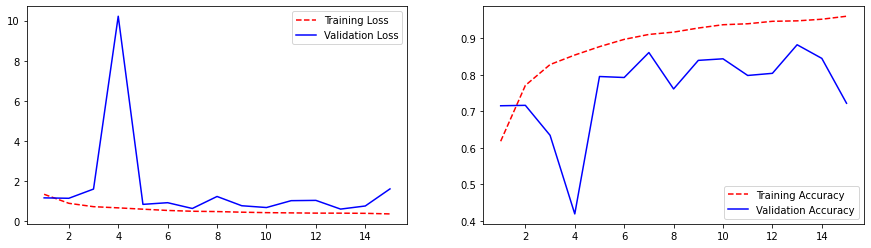

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = inceptionet_history.history['loss']
validation_loss = inceptionet_history.history['val_loss']

training_accuracy = inceptionet_history.history['accuracy']
validation_accuracy = inceptionet_history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

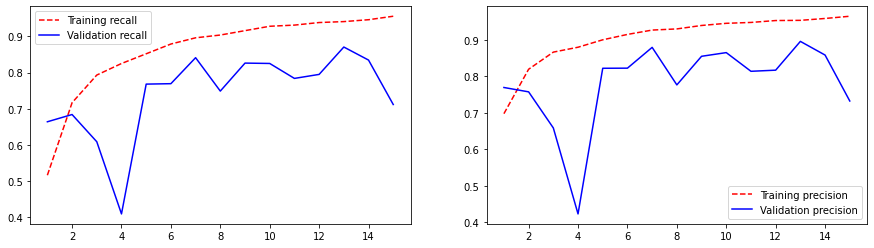

In [13]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_recall = inceptionet_history.history['recall']
validation_recall = inceptionet_history.history['val_recall']
training_precision = inceptionet_history.history['precision']
validation_precision =inceptionet_history.history['val_precision']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_recall, 'r--')
axs[0].plot(epoch_count, validation_recall, 'b-')
axs[0].legend(['Training recall', 'Validation recall'])

axs[1].plot(epoch_count, training_precision, 'r--')
axs[1].plot(epoch_count, validation_precision, 'b-')
axs[1].legend(['Training precision', 'Validation precision'])


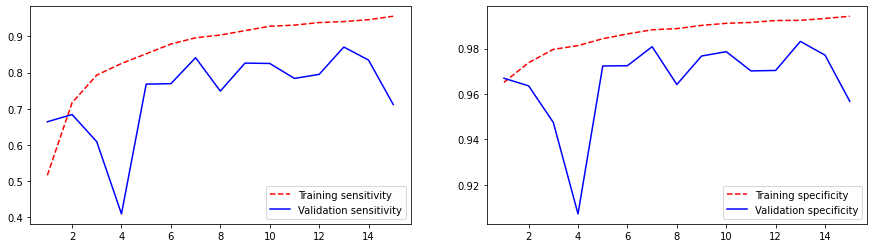

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_mean_iou =inceptionet_history.history['sensitivity']
validation_mean_iou = inceptionet_history.history['val_sensitivity']

training_specificity = inceptionet_history.history['specificity']
validation_specificity = inceptionet_history.history['val_specificity']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_mean_iou, 'r--')
axs[0].plot(epoch_count, validation_mean_iou, 'b-')
axs[0].legend(['Training sensitivity', 'Validation sensitivity'])

axs[1].plot(epoch_count, training_specificity, 'r--')
axs[1].plot(epoch_count, validation_specificity, 'b-')
axs[1].legend(['Training specificity', 'Validation specificity'])